# Data Dictionary: Land Management Schemes [Oct 2022]


## Contents

1. Introduction
2. Data used in this analysis
3. Manage the GIS
4. Data pre-processing
5. Analysis

## Introduction 

This is a reproducible data dictionary based on a python script to scrape Natural England and Forestry Commission open data in order to perform analysis for National Parks England. As this is a script, it can be re-run as and when the data is updated. Moreover, this analysis is reproducible meaning this analysis can be copied or investigated and improved on. For further details contact;

david.alexander@peakdistrict.gov.uk

The area managed under agri-environment agreements: ie the total area under Environmental Stewardship (ES), Countryside Stewardship (CS) (including its different levels), and area under England Woodland Grant Scheme (EWGS)

## Data used in this analysis

#### Environmental Stewardship (ES)

**ES** is an agri-environment scheme which provides funding to farmers and other land managers in England who deliver effective environmental management on their land.

It has four elements:

* Entry Level Stewardship (ELS)
* Organic Entry Level Stewardship (OELS)
* Uplands Entry Level Stewardship (Uplands ELS)
* Higher Level Stewardship (HLS).

Upland ELS can apply to any agreement with an ELS or OELS component and therefore their figures are subsumed in the ELS, ELS/HLS, OELS and OELS/HLS categories.

Data available;

1. **Environmental Stewardship Scheme (England) holdings agreement** polygons (includes farm business and payment info).
2. **Environmental Stewardship Scheme (England) options** points derived from Genesis tables.

#### Countryside Stewardship (CS)

**CS** is an agri-environment scheme with Higher Tier, full Mid tier, Mid Tier wildlife packages and Hedgerows and Boundaries grant schemes.

Data available;

3. **Countryside Stewardship Scheme 2016-2020 Management Areas** geographic extent and location of all land under management within the Countryside Stewardship Agri-Environment Scheme.
4. **Countryside Stewardship Scheme Agreements holding boundaries data.**
5. **Countryside Stewardship Scheme Agreement Option points.**

#### England Woodland Grants Scheme (EWGS)

**EWGS** is the legacy England Woodland Grant Scheme by the Forestry Commission. EWGS is now closed and was superseded by Countryside Stewardship in 2015.

Data available;

6. **English Woodland Grant Scheme Boundary** the English Woodland Grant Scheme (EWGS) was launched in 2005 and offered 6 grants for the creation and stewardship of woodlands. This dataset contains the scheme or 'case' boundaries that make up the EWGS applications approved by the Forestry Commission. EWGS is now closed and was superseded by Countryside Stewardship in 2015.

7. **England Woodland Grant Scheme 1** WGS1 operated between June 1988 and June 1991. It was replaced by WGS2.

8. **England Woodland Grant Scheme 2** the dataset identifies areas approved by grant type. As the boundaries of the scheme were never digitised, an approximation polygon was created for each scheme. The approximation is based on the Ordnance Survey grid reference held for each scheme; this point location being buffered by a distance proportional to the total area of the scheme. WGS2 operated between June 1991 and September 1994. It was replaced by WGS3

9. **England Woodland Grant Scheme 3** there are two spatial datasets associated with the WGS. These represent the scheme boundary and the grant areas that are encapsulated by this scheme boundary.WGS3 was operative from October 1994 until its closure to new applications in June 2004.

#### Further information
The PDNPA and other NPAs also have their own small scale Land Management Grant Scheme not currently in this analysis.



## Manage the GIS

#### Run this cell to connect to your GIS and get started:

In [1]:
from arcgis.gis import GIS
from arcgis.features.manage_data import extract_data
from arcgis.geometry import LengthUnits, AreaUnits
from arcgis.features import GeoSeriesAccessor
import arcpy
import os
import pandas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
gis = GIS("home")
print(gis)

GIS @ https://www.arcgis.com version:10.2


## Get the data for analysis

All data used comes from the ESRI [living Atlas](https://livingatlas.arcgis.com/en/home/) layers as the sources of data

In [2]:
# Title: Countryside Stewardship Scheme 2016 Management Areas (England) | Type: Feature Service | Owner: Opendata_NE
CS_item = gis.content.get('b63046f37b5d4869b47ed16d4e23a168')
# Title: Environmental Stewardship Scheme Agreements (England) | Type: Feature Service | Owner: Opendata_NE
ES_item = gis.content.get('ca68c90958c342a285d6370ddd7edd66')
# Title: English Woodland Grant Scheme Boundary | Type: Feature Service | Owner: mapping.geodata_forestry
EWGS_item = gis.content.get('b04623c9c3d046e8a4e94666b6617df8')
# Title: Woodland Grant Scheme 1 England | Type: Feature Service | Owner: mapping.geodata_forestry
EWGS_1_item = gis.content.get('d527d55fd5104e80b1bf2d80643f5865')
# Title: Woodland Grant Scheme 2 England | Type: Feature Service | Owner: mapping.geodata_forestry
EWGS_2_item = gis.content.get('9752787986da4f44b4abd4bd4f494605')
# Title: Woodland Grant Scheme 3 England | Type: Feature Service | Owner: mapping.geodata_forestry
EWGS_3_item = gis.content.get('3e26fc54a1d4479f90d5f268cc83a0a9')
# Title: National Parks (England) | Type: Feature Service | Owner: Opendata_NE
NPE_item = gis.content.get('d333c7529754444894e2d7f5044d1bbf')

<Item title:"Countryside Stewardship Scheme 2016 Management Areas (England)" type:Feature Layer Collection owner:Opendata_NE>
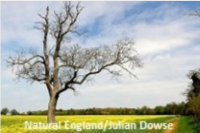

<Item title:"Environmental Stewardship Scheme Agreements (England)" type:Feature Layer Collection owner:Opendata_NE>
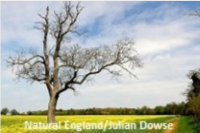

<Item title:"English Woodland Grant Scheme Boundary" type:Feature Layer Collection owner:mapping.geodata_forestry>
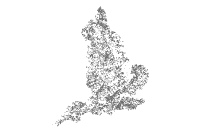

<Item title:"Woodland Grant Scheme 1 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
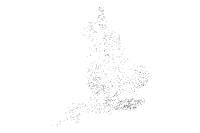

<Item title:"Woodland Grant Scheme 2 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
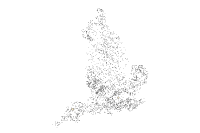

<Item title:"Woodland Grant Scheme 3 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
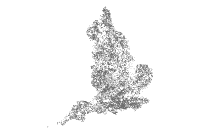

<Item title:"National Parks (England)" type:Feature Layer Collection owner:Opendata_NE>
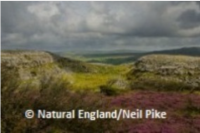

In [3]:
# display the items
data = [CS_item, ES_item, EWGS_item, EWGS_1_item, EWGS_2_item, EWGS_3_item, NPE_item]
for item in data:
    display(item)

In [4]:
# Take the layer ready for pre-processing
ES = ES_item.layers[0]
CS = CS_item.layers[0]
EWGS = EWGS_item.layers[0]
NPE = NPE_item.layers[0]

## Data pre-processing

1. Clip the data to National Parks England (NPE) boundaries

2. Create a new column [END_YEAR] and extract the calendar year from [ENDDATE] in the dataframe

3. Create a new column [AREA_CLIP] using the clipped geometry and add the calculated area (as data has been clipped some agreements overlap the boundary). This new column shows the area (sqkm) just inside the National Parks boundary. This uses n intermediate [GeoSeriesAccessor](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#geoseriesaccessor) object. This class allows you to perform operations like area, extent, etc., on an entire series of shapes, which avoids needing to iterate over your dataframe.  

4. Sjoin the NPE data to the ES and CS data so the data can be analysed collectively and individually for all NP's




Clip the data to NPE Boundaries

In [ ]:
# Cut the ES layer
from arcgis import features
features.manage_data.extract_data(input_layers=[ES],
                         extent=NPE,
                         clip=True,
                         data_format='ShapeFile',
                         output_name='ES_NE')

In [14]:
# Cut the CS layer
features.manage_data.extract_data(input_layers=[CS],
                         extent=NPE,
                         clip=True,
                         data_format='ShapeFile',
                         output_name='CS_NPE')

In [24]:
# Cut the EWGS layer
features.manage_data.extract_data(input_layers=[EWGS],
                         extent=NPE,
                         clip=True,
                         data_format='ShapeFile',
                         output_name='EWGS_NPE')

<Item title:"EWGS_NPE" type:Shapefile owner:david.alexander_PDNPA>

Create new columns for analysis by area and end date 

In [5]:
# Add the cut layers to wd
ES_NPE = gis.content.get('e9e9692660fa42e38bead960021e8c41').layers[0]
CS_NPE = gis.content.get('207f7a1ec7ee4f10a169d6fb25aabd37').layers[0]
EWGS_NPE = gis.content.get('60d4d326838f4c78811452b3160412bc').layers[0]

Process the data for Environmental Stewardship

In [7]:
# Create a dataframe
ES_NPE_df = ES_NPE.query().sdf
# Create the End Year for pivot
ES_NPE_df['END_YEAR'] = pd.DatetimeIndex(ES_NPE_df['ENDDATE']).year
# Create the area column using an intermediate GeoSeriesAccessor
gsa = GeoSeriesAccessor(ES_NPE_df['SHAPE'])
ES_NPE_df['new_area_field'] = gsa.area
# Check the data :)
ES_NPE_df.head(2)

,FID,AGREF,CPH,CUSTNAME,TOWN,SCHEME,REGION,NCA,LAND_CTY,ELSAREA,...,EDUACS,UELSFLG,BUS_FLAG,Shape__Are,Shape__Len,Shape__Area,Shape__Length,SHAPE,END_YEAR,new_area_field
0,1,AG00252239,481680003,GREEN FARMING LTD,Scarborough,Entry Level plus Higher Level Stewardship,Yorkshire and the Humber,NORTH YORKSHIRE MOORS AND CLEVELAND HILLS,North Yorkshire,13338.92,...,N,N,Y,4.791905e+06,38605.592965,6.016249e+06,23725.477208,"{""rings"": [[[-48239.066137503, 7235184.2861492...",2023,6016249.455025
1,2,AG00267487,90830045,P W Wood,Buxton,Entry Level plus Higher Level Stewardship,East Midlands,WHITE PEAK,Derbyshire,2204.32,...,N,N,N,1.031624e+06,6056.620643,2.879406e+06,10117.532802,"{""rings"": [[[-191087.4443051, 7029996.51367184...",2023,2879405.551827


Process the data for Countryside Stewardship

In [14]:
# Create a dataframe
CS_NPE_df = CS_NPE.query().sdf
# Create the End Year for pivot
CS_NPE_df['END_YEAR'] = pd.DatetimeIndex(CS_NPE_df['ENDDATE']).year
# Create the area column using an intermediate GeoSeriesAccessor
gsa = GeoSeriesAccessor(CS_NPE_df['SHAPE'])
CS_NPE_df['new_area_field'] = gsa.area
# Check the data :)
CS_NPE_df.head(2)

,FID,CSREF,STATUS,CS_TYPE,STARTDATE,ENDDATE,ORG_NAME,DURATION,TOTVAL,GROSSAR,...,TOTVAL_NO,APP_YEAR,MAG_CS_TYP,Shape__Are,Shape__Len,Shape__Area,Shape__Length,SHAPE,END_YEAR,new_area_field
0,1,116947,Agreement Live,Higher Tier,01-01-2016 00:00:00,31-12-2025 00:00:00,DEVON WILDLIFE TRUST,10,133689.28,0.0,...,133689.28,2015,COUNTRYSIDE STEWARDSHIP (Higher Tier),557701.850870,8143.404047,1.382012e+06,12822.176876,"{""rings"": [[[-433724.655357367, 6545427.972096...",2025,1382011.529947
1,2,301345,Agreement Live,Higher Tier,01-01-2017 00:00:00,31-12-2026 00:00:00,C R Abel,10,23729.81,0.0,...,23729.81,2016,COUNTRYSIDE STEWARDSHIP (Higher Tier),341390.899694,4361.879957,8.474560e+05,6873.098659,"{""rings"": [[[-453123.398479023, 6556360.924097...",2026,847455.949266


Process the data for England Woodland Grant Scheme

In [6]:
# Create a dataframe
EWGS_NPE_df = EWGS_NPE.query().sdf
# Create the area column using an intermediate GeoSeriesAccessor
gsa = GeoSeriesAccessor(EWGS_NPE_df['SHAPE'])
EWGS_NPE_df['new_area_field'] = gsa.area
# Check the data :)
EWGS_NPE_df.head(2)

,FID,CaseRef,PropName,FSArea,CaseType,DateApprv,CurrStat,AreaHa,Shape__Area,Shape__Length,SHAPE,new_area_field
0,1,112,Kentmere Hall Estate,North West and West Midlands,EWGS,2006-02-10,Closed,10.017777,295537.000488,2950.251703,"{""rings"": [[[-316824.907964989, 7251259.865548...",295537.007987
1,2,124,Brookman Woodlands Sunderland Gill - WPG,North West and West Midlands,EWGS,2006-01-11,Closed,27.086416,810040.009766,4171.248038,"{""rings"": [[[-362750.771154887, 7305354.096873...",810040.030245


Alinh the spatial reference and join the data ready for NPE analysis

In [7]:
# Create a dataframe from the NPE boundaries
NPE_df = NPE.query().sdf
NPE_df.spatial.sr

{'wkid': 27700, 'latestWkid': 27700}

In [15]:
# Convert spatial ref to 27700 for spatial join
ES_NPE_df['SHAPE'] = ES_NPE_df['SHAPE'].geom.project_as(27700)
CS_NPE_df['SHAPE'] = CS_NPE_df['SHAPE'].geom.project_as(27700)
EWGS_NPE_df['SHAPE'] = EWGS_NPE_df['SHAPE'].geom.project_as(27700)

In [17]:
# spatial join
ES_NPE_df = ES_NPE_df.spatial.join(NPE_df)
CS_NPE_df.spatial.join(NPE_df)
EWGS_NPE_df = EWGS_NPE_df.spatial.join(NPE_df)

In [18]:
# Export the finish layers to a feature layer
ES_NPE_lyr = ES_NPE_df.spatial.to_featurelayer(title = 'ES_NPE_cut', tags = 'Land Management')
CS_NPE_lyr = CS_NPE_df.spatial.to_featurelayer(title = 'CS_NPE_cut', tags = 'Land Management')
EWGS_NPE_lyr = EWGS_NPE_df.spatial.to_featurelayer(title = 'EWGS_NPE_cut', tags = 'Land Management')

In [20]:
EWGS_NPE_lyr

<Item title:"EWGS_NPE_cut" type:Feature Layer Collection owner:david.alexander_PDNPA>

## Analysis

In [2]:
# Add the final layers for anlaysis
ES = gis.content.get('4361f2945767465880d32c4593b861d3').layers[0]
CS = gis.content.get('10541b12af654bc892797d8a7cb80e71').layers[0]
EWGS = gis.content.get('5b50c5997876412fb5c3ef3c5e6cd49c').layers[0]

In [ ]:
# Create a df
ES = ES.query().sdf
CS = CS.query().sdf
EWGS = EWGS.query().sdf

Take a look at the data on a map

In [7]:
Map = gis.map()
Map.basemaps = 'terrain'
Map.add_layer(ES)
Map.add_layer(CS)
Map.add_layer(EWGS)
Map

MapView(layout=Layout(height='400px', width='100%'))